# <font color=darkred> Gridworld policy improvement</font>

## <font color=darkblue> Policy improvement (deterministic case) on a simple gridworld example </font>

The objective is to randomly initialize the policy and then to alternate between policy improvement and policy evaluation : 
- policy improvement is part of the control problem. For a particular state s, if the policy is to go up, then we are trying to go left, right or down and if the state-value is bigger, then we change the policy for this particular state to this new action. 
- policy evaluation : when an action is changed, then the policy is different so the value table needs to be updated. This is the aim of this prediction problem, calculate the value table, being given a policy. 

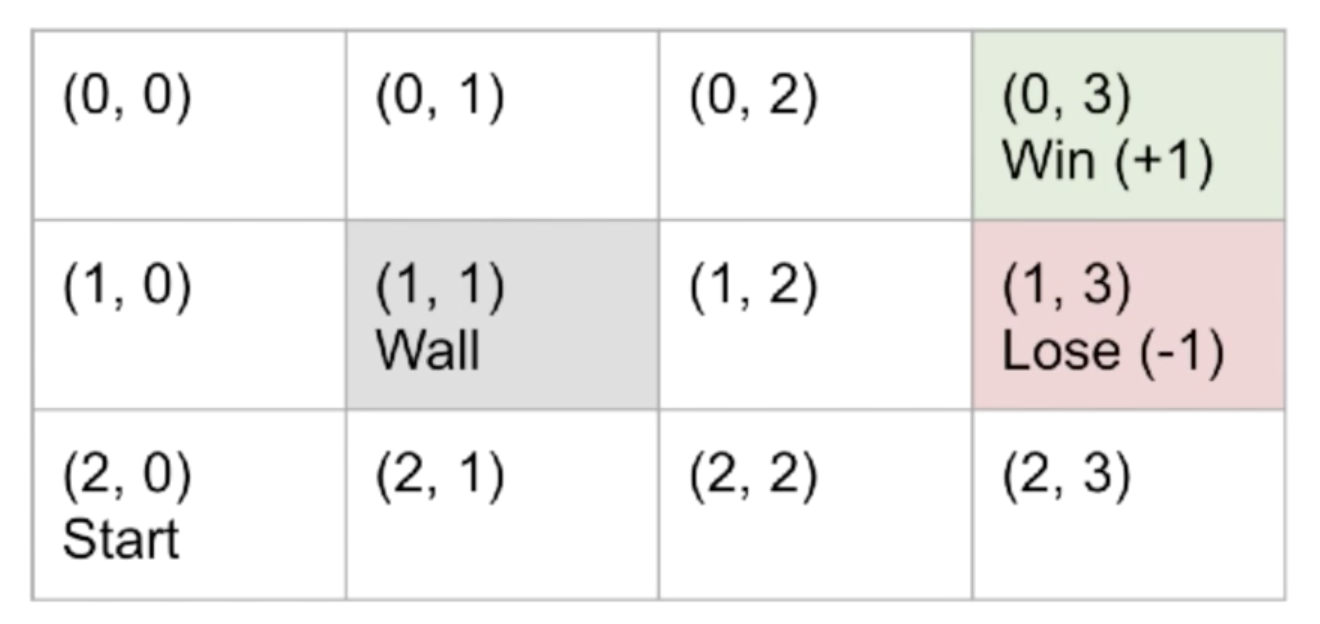

In [1]:
import numpy as np
ACTION_SPACE=['U','D','L','R']

In [2]:
class Gridworld:
    def __init__(self, row, col, start):
        self.rows=row
        self.cols=col
        self.i=start[0]
        self.j=start[1]
        
    def set(self, rewards, actions):
        self.reward = rewards
        self.action = actions
        
    #set the state to s for the gridworld object
    def set_state(self,s): 
        self.i=s[0]
        self.j=s[1]
    
    #returns the current state of the grid
    def current_state(self):
        return((self.i,self.j))
    
    #returns True if the state s is a terminal state (i.e: not in the action dictionnary)
    def is_terminal(self,s):
        return(s not in self.action.keys())
    
    #returns the coordonates of the next state given the action a 
    def get_next_state(self,s,a):
        i,j = s[0],s[1]
        #check if the action is permitted or not
        if a in self.action[(i,j)]:
            if a=='R':
                j+=1
            elif a=='L':
                j-=1
            elif a=='U':
                i-=1
            elif a=='D':
                i+=1
        return((i,j))
    
    #return the reward after the action was taking into account (by default reward is 0)
    def move(self,a):
        #check if the action is permitted or not
        i,j = s[0],s[1]
        if a in self.action[(i,j)]:
            if a=='R':
                self.j+=1
            elif a=='L':
                self.j-=1
            elif a=='U':
                self.i-=1
            elif a=='D':
                self.i+=1
        if (self.i,self.j) in self.reward.keys():
            return(self.reward[(self.i,self.j)])
        else:
            return(0)
        
    #return the modified grid when decide to step back one step before action a   
    def undo_move(self,a):
        if a=='R':
            self.j-=1
        elif a=='L':
            self.j+=1
        elif a=='U':
            self.i+=1
        elif a=='D':
            self.i-=1
        # raise an exception if we arrive somewhere we shouldn't be
        # should never happen
        assert(self.current_state() in self.all_states())
    
    def game_over(self):
        return((self.i,self.j) in self.reward)
    
    def all_states(self):
        return(set(self.action.keys() | self.reward.keys()))

In [3]:
def standard_grid():
    g = Gridworld(3,4,[2,0])
    rewards = {(0,3):+1,
              (1,3):-1}
    actions = {(0,0):('R','D'),
               (0,1):('R','L'),
               (0,2):('D','R','L'),
               (1,0):('U','D'),
               (1,2):('U','D','R'),
               (2,0):('U','R'),
               (2,1):('R','L'),
               (2,2):('U','R','L'),
               (2,3):('U','L')}
    g.set(rewards,actions)
    return(g)

In [4]:
def print_value(V,g):
    for i in range(g.rows):
        print("----------------------------")
        for j in range(g.cols):
            v = V.get((i,j),0)
            if v>=0:
                print(" %.2f |" %v, end="")
            else:
                print("%.2f |" %v, end="")
        print()

In [5]:
def print_policy(P,g):
    for i in range(g.rows):
        print("----------------")
        for j in range(g.cols):
            p = P.get((i,j),' ')
            print(" %s |" %p, end="")
        print()

In [6]:
def get_transition_probs_and_rewards(grid):
    #This dictionnary gives the distributions p(s'|s,a). 
    #If the key is (s,a,s'), then transition_probs[(s,a,s')] is p(s'|s,a)
    transition_probs={}

    #We use here deterministic rewards. 
    #If the key is (s,a,s'), then rewards[(s,a,s')] is the reward of state s'
    rewards={}

    for i in range(grid.rows):
        for j in range(grid.cols):
            s=(i,j)
            if not grid.is_terminal(s):
                for a in ACTION_SPACE:
                    s2 = grid.get_next_state(s,a)
                    #print("current state is ",s," and action is ",a," and next state is ",s2)
                    transition_probs[(s,a,s2)]=1 #deterministic transition probabilities
                    if s2 in grid.reward.keys():
                        rewards[(s,a,s2)]=grid.reward[s2]
                    else:
                        rewards[(s,a,s2)]=0
                        
    return(transition_probs,rewards)

In [7]:
def iterative_policy_evaluation(policy,g):
    global threshold, gamma
    
    # initialize V(s) to 0
    V={}
    for s in g.all_states():
        V[s]=0
    
    #Discount factor
    gamma = 0.9
    
    #threshold argument to stop the loop when convergence
    threshold = 0.001
    
    #transition_probs and reward
    transition_probs, rewards = get_transition_probs_and_rewards(g)
    
    #Main loop
    it=0
    while True:
        biggest_change = 0
        for s in g.all_states():
            if not g.is_terminal(s):
                old_v=V[s]
                new_v=0
                for a in ACTION_SPACE:
                    for s2 in g.all_states():
                        action_probs=1 if policy.get(s)==a else 0
                        r = rewards.get((s,a,s2),0) #reward is 0 if not specified
                        new_v += action_probs*transition_probs.get((s,a,s2),0)*(r+gamma*V[s2])
                        
                #after done getting the new value, update the V-table
                V[s]=new_v
                biggest_change = max(biggest_change,np.abs(V[s]-old_v))
                
        it+=1       
        #print_value(V,g)
        #print("")
        #print("Iteration: ",it,"biggest change: ", biggest_change )
        #print("")
        if biggest_change <= threshold: 
            break
    return(V)

In [102]:
#initializing the grid and its transition probabilities and rewards
grid = standard_grid()
transition_probs, rewards = get_transition_probs_and_rewards(grid)

#randomly initialize the policy
policy = {}
for s in grid.action.keys():
    policy[s]=np.random.choice(ACTION_SPACE)

#Evaluate the value of each state given this initialized policy
V = iterative_policy_evaluation(policy, grid)

#print the initial policy and value table 
print("The initial policy is the following one :")
print_policy(policy,grid)
print("")

print("The initial value table is the following one :")
print_value(V,grid)

The initial policy is the following one :
----------------
 R | U | D |   |
----------------
 L |   | U |   |
----------------
 R | U | D | U |

The initial value table is the following one :
----------------------------
 0.00 | 0.00 | 0.00 | 0.00 |
----------------------------
 0.00 | 0.00 | 0.00 | 0.00 |
----------------------------
 0.00 | 0.00 | 0.00 |-1.00 |


In [103]:
while True :
    is_policy_converged = True
    for s in grid.action.keys():
        old_a = policy[s]
        new_a = None
        best_value = float('-inf')

        for a in ACTION_SPACE:
            new_value=0
            for s2 in grid.all_states():
                r = rewards.get((s,a,s2),0)
                new_value+=transition_probs.get((s,a,s2),0)*(r+gamma*V[s2])
            if new_value>best_value:
                best_value=new_value
                new_a = a
                
        #if a better action is found, then the policy changes and the value table needs to be updated
        if new_a != old_a : 
            policy[s]=new_a
            V = iterative_policy_evaluation(policy,grid)
            is_policy_converged=False
            
    #if the for loop is completed, and no action was changed on any state, it means 
    #the current policy is the optimal one
    if is_policy_converged: break
        

print("The best policy found is the following one :")   
print_policy(policy,grid)
print("")
print("The corresponding value table is the following one :")   
print_value(V,grid)
        

The best policy found is the following one :
----------------
 R | R | R |   |
----------------
 U |   | U |   |
----------------
 U | R | U | L |

The corresponding value table is the following one :
----------------------------
 0.81 | 0.90 | 1.00 | 0.00 |
----------------------------
 0.73 | 0.00 | 0.90 | 0.00 |
----------------------------
 0.66 | 0.73 | 0.81 | 0.73 |


## <font color=darkblue> Conclusion and remarks </font>

We can see that the policy found by the algorithm is the optimal one. The starting point policy is to go up, but it could also be to go right because the state-value is the same whether the policy says to go up or right. 